In [63]:
import sys
sys.path.append('../..')

import logging
import os
import time
import yaml
import pandas as pd
from src.utils.wrapper import make_env, CustomWrapper
from stable_baselines3.common.vec_env import SubprocVecEnv
from stable_baselines3.common.evaluation import evaluate_policy

logger = logging.getLogger(__name__)

In [57]:
config = yaml.load(open("../../configs/evaluation.yaml", "r"), Loader=yaml.SafeLoader)
folder_to_agents = config["evaluation"]["folder_to_agents"]
DISCRETE_ACTION_SPACE = config["evaluation"]["discrete_action_space"]

# list all folders but not files



    


In [58]:
def get_agent_folders(folder_to_agents):
    list_of_agents = [name for name in os.listdir(folder_to_agents) if os.path.isdir(os.path.join(folder_to_agents, name))]
    for agent_folder in list_of_agents:
        # check if folder has file named "best_model.zip"
        if not os.path.isfile(os.path.join(folder_to_agents, agent_folder, "best_model.zip")):
            print("Skipping {agent_folder} because it does not contain a best_model.zip file")
            list_of_agents.remove(agent_folder)
        
        # check if folder has file that ends with .txt
        if not any([file.endswith(".txt") for file in os.listdir(os.path.join(folder_to_agents, agent_folder))]):
            print(f"Skipping {agent_folder} because it does not contain a txt file")
            list_of_agents.remove(agent_folder)

    return list_of_agents

In [59]:
def get_all_possibilities(list_of_agents):
    model_vs_model = [(agent1, agent2, "weak") for agent1 in list_of_agents for agent2 in list_of_agents if agent1 != agent2]
    model_vs_strong = [(agent1, None, "strong") for agent1 in list_of_agents]
    model_vs_weak = [(agent1, None, "weak") for agent1 in list_of_agents]
    return model_vs_model + model_vs_strong + model_vs_weak

In [60]:
def evaluate_model_vs_model(
    agent_1, agent_2, config, DISCRETE_ACTION_SPACE, weak_opponent=True
):
    model1 = CustomWrapper.load_model_from_disk(agent_1)
    eval_env = SubprocVecEnv(
        [
            make_env(
                i,
                mode=CustomWrapper.NORMAL,
                discrete_action_space=DISCRETE_ACTION_SPACE,
                negativ_reward=True,
                weak=weak_opponent,
            )
            for i in range(config["evaluation"]["n_eval_envs"])
        ],
        start_method=config["evaluation"]["start_method"],
    )
    eval_env.render_mode = config["evaluation"]["render_mode"]

    if isinstance(agent_2, str):
        eval_env.env_method("set_opponent", agent_2)
    else:
        agent_2 = "Weak Opponent" if weak_opponent else "Strong Opponent"

    obs = eval_env.reset()
    logger.info(f"Evaluating {agent_1} vs {agent_2}")
    mean_reward, std_reward = evaluate_policy(
        model1,
        eval_env,
        n_eval_episodes=config["evaluation"]["n_eval_episodes"],
        deterministic=True,
    )
    logger.info(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")
    return mean_reward, std_reward



In [61]:
list_of_agents = get_agent_folders(folder_to_agents)
agent1 = folder_to_agents + "/" + list_of_agents[0]
agent2 = folder_to_agents + "/" + list_of_agents[1]
evaluate_model_vs_model(agent1, agent2, config, DISCRETE_ACTION_SPACE)

(-7.3444214, 10.71715845245356)

In [69]:
evaluate_model_vs_model("../../../agents/td3_corne", "../../../agents/best_old", config, DISCRETE_ACTION_SPACE, weak_opponent=False)

(-4.84630696, 10.577952936287751)

In [62]:
evaluate_model_vs_model(agent1, None, config, DISCRETE_ACTION_SPACE, weak_opponent = True)

(9.65624361, 0.34434120010675157)

In [66]:
matches = get_all_possibilities(list_of_agents)
base_path = config["evaluation"]["folder_to_agents"]
agent1 = matches[0][0]
agent1_path = f"{base_path}/{agent1}"
agent1_path

'../../../agents/td3_corne'

In [70]:
all_players = ["weak", "strong"] + list_of_agents
df_mean = pd.DataFrame(columns = all_players, index = all_players)
df_std = pd.DataFrame(columns = all_players, index = all_players)
base_path = config["evaluation"]["folder_to_agents"]

matches = get_all_possibilities(list_of_agents)
for agent1, agent2, opponent in matches:
    if agent2 == None:
        agent1_path = f"{base_path}/{agent1}"
        print(agent1_path)
        mean_reward, std_reward = evaluate_model_vs_model(agent1_path, agent2, config,DISCRETE_ACTION_SPACE, opponent)
        df_mean.loc[agent1, opponent] = mean_reward
        df_mean.loc[opponent, agent1] = mean_reward
        df_std.loc[agent1, opponent] = std_reward
        df_std.loc[opponent, agent1] = std_reward
    else:
        agent1_path = f"{base_path}/{agent1}"
        agent2_path = f"{base_path}/{agent2}"
        print(agent1_path)
        print(agent2_path)
        mean_reward, std_reward = evaluate_model_vs_model(agent1_path, agent2_path, config, DISCRETE_ACTION_SPACE,opponent)
        df_mean.loc[agent1, agent2] = mean_reward
        df_mean.loc[agent2, agent1] = mean_reward
        df_std.loc[agent1, agent2] = std_reward
        df_std.loc[agent2, agent1] = std_reward
    
    save_location = config["evaluation"]["save_location"]
    # check if folder exists
    if not os.path.isdir(save_location):
        os.makedirs(save_location)

    save_path_mean = os.path.join(save_location, "df_mean.csv")
    save_path_std = os.path.join(save_location, "df_std.csv")
    df_mean.to_csv(save_path_mean)
    df_std.to_csv(save_path_std)



../../../agents/td3_corne
../../../agents/best_old
../../../agents/td3_corne
../../../agents/trial_11
../../../agents/best_old
../../../agents/td3_corne


KeyboardInterrupt: 

In [47]:
matches

[('td3_corne', 'best_old', 'weak'),
 ('td3_corne', 'trial_11', 'weak'),
 ('best_old', 'td3_corne', 'weak'),
 ('best_old', 'trial_11', 'weak'),
 ('trial_11', 'td3_corne', 'weak'),
 ('trial_11', 'best_old', 'weak'),
 ('td3_corne', None, 'strong'),
 ('best_old', None, 'strong'),
 ('trial_11', None, 'strong'),
 ('td3_corne', None, 'weak'),
 ('best_old', None, 'weak'),
 ('trial_11', None, 'weak')]

In [71]:
from typing import Optional

In [75]:
df = pd.read_csv("../../../evaluations/df_mean.csv", index_col=0)

In [76]:
df

,weak,strong,td3_corne,best_old,trial_11
weak,NaN,NaN,9.720379,9.725139,8.268142
strong,NaN,NaN,9.639970,9.658591,8.321843
td3_corne,9.720379,9.639970,-0.691733,-1.744819,-0.718178
best_old,9.725139,9.658591,-1.744819,-3.557858,-11.610917
trial_11,8.268142,8.321843,-0.718178,-11.610917,-0.835851


In [190]:
p = "/Users/corneliuswiehl/Library/CloudStorage/GoogleDrive-corneliuswiehl@googlemail.com/My Drive/Studium/Master/ReinforcementLearning/Project/logs/hyper_td3/hyperparameter_search_td3_5.csv"
df = pd.read_csv(p)

In [191]:
df = df.sort_values(by="mean_reward", ascending=False)

In [192]:
def helper(x):
    ls = x.split(",")
    #ls.pop(9)
    #ls.pop(9)
    ls = ls[:9]
    x = ",".join(ls)
    x = x+"}"
    return x

df["params"] = df["params"].apply(helper)
df["params"] = df["params"].apply(lambda x: eval(x))

In [193]:
df2 = df["params"].apply(pd.Series)
df = pd.concat([df, df2], axis=1)

In [194]:
#show more columns
pd.set_option("display.max_columns", 100)
df

,Unnamed: 0,params,normalize,negativ_reward,discrete_action_space,training_time,mean_reward,std_reward,model_type,policy,n_timesteps,run_name,best_agent_mean_reward,best_agent_std_reward,gamma,learning_rate,batch_size,buffer_size,train_freq,gradient_steps,policy_kwargs,tau
41,0,"{'gamma': 0.99, 'learning_rate': 0.00089000000...",True,True,False,513.083880,9.065880,0,TD3,<class 'stable_baselines3.td3.policies.TD3Poli...,2000000,hyper_td3_3_152,5.20,0,0.9900,0.00089,2048,100000,256,256,"{'net_arch': [256, 256]}",0.050
39,0,"{'gamma': 0.99, 'learning_rate': 0.00089000000...",True,True,False,506.127612,8.998758,0,TD3,<class 'stable_baselines3.td3.policies.TD3Poli...,2000000,hyper_td3_3_150,3.80,0,0.9900,0.00089,2048,100000,256,256,"{'net_arch': [256, 256]}",0.050
24,0,"{'gamma': 0.99, 'learning_rate': 0.00092000000...",True,True,False,480.639520,8.701502,0,TD3,<class 'stable_baselines3.td3.policies.TD3Poli...,2000000,hyper_td3_3_135,4.42,0,0.9900,0.00092,2048,100000,256,256,"{'net_arch': [256, 256]}",0.050
33,0,"{'gamma': 0.99, 'learning_rate': 0.00067000000...",True,True,False,530.962391,8.616221,0,TD3,<class 'stable_baselines3.td3.policies.TD3Poli...,2000000,hyper_td3_3_144,3.50,0,0.9900,0.00067,2048,100000,256,256,"{'net_arch': [256, 256]}",0.050
29,0,"{'gamma': 0.99, 'learning_rate': 0.00090000000...",True,True,False,498.010262,8.212944,0,TD3,<class 'stable_baselines3.td3.policies.TD3Poli...,2000000,hyper_td3_3_140,2.88,0,0.9900,0.00090,2048,100000,256,256,"{'net_arch': [256, 256]}",0.050
26,0,"{'gamma': 0.99, 'learning_rate': 0.00093, 'bat...",True,True,False,486.740912,8.004575,0,TD3,<class 'stable_baselines3.td3.policies.TD3Poli...,2000000,hyper_td3_3_137,2.40,0,0.9900,0.00093,2048,100000,256,256,"{'net_arch': [256, 256]}",0.050
27,0,"{'gamma': 0.99, 'learning_rate': 0.00092000000...",True,True,False,492.922369,7.990149,0,TD3,<class 'stable_baselines3.td3.policies.TD3Poli...,2000000,hyper_td3_3_138,3.74,0,0.9900,0.00092,2048,100000,256,256,"{'net_arch': [256, 256]}",0.050
45,0,"{'gamma': 0.999, 'learning_rate': 0.0008600000...",True,True,False,491.008016,7.920064,0,TD3,<class 'stable_baselines3.td3.policies.TD3Poli...,2000000,hyper_td3_3_156,4.50,0,0.9990,0.00086,2048,100000,256,256,"{'net_arch': [256, 256]}",0.050
8,0,"{'gamma': 0.99, 'learning_rate': 0.00092000000...",True,True,False,375.448430,7.904339,0,TD3,<class 'stable_baselines3.td3.policies.TD3Poli...,2000000,hyper_td3_3_119,2.42,0,0.9900,0.00092,1024,10000000,1024,1024,"{'net_arch': [256, 256]}",0.050
30,0,"{'gamma': 0.99, 'learning_rate': 0.00090000000...",True,True,False,525.877762,7.851392,0,TD3,<class 'stable_baselines3.td3.policies.TD3Poli...,2000000,hyper_td3_3_141,4.00,0,0.9900,0.00090,2048,100000,256,256,"{'net_arch': [256, 256]}",0.050


In [195]:
df["params"].values[0]

{'gamma': 0.99,
 'learning_rate': 0.0008900000000000001,
 'batch_size': 2048,
 'buffer_size': 100000,
 'train_freq': 256,
 'gradient_steps': 256,
 'policy_kwargs': {'net_arch': [256, 256]},
 'tau': 0.05}

In [150]:
def network(x,y):
    l1 = -4*x+2*y+3
    l2 = x+3*y-2

    l1 = max(0,l1)
    l2 = max(0,l2)

    return l1*2+l2*3-2



In [161]:
# define grid from -10 to 10
import numpy as np
x = np.linspace(-10,10,100)
y = np.linspace(-10,10,100)

# create meshgrid
X,Y = np.meshgrid(x,y)

res = []
for x,y in zip(X.flatten(),Y.flatten()):
    res.append((x,y,network(x,y)))

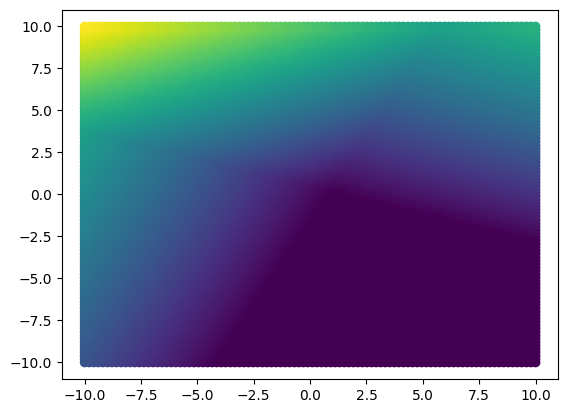

In [163]:
# plot points by color depending on value
import matplotlib.pyplot as plt
plt.scatter([x[0] for x in res],[x[1] for x in res],c=[x[2] for x in res])

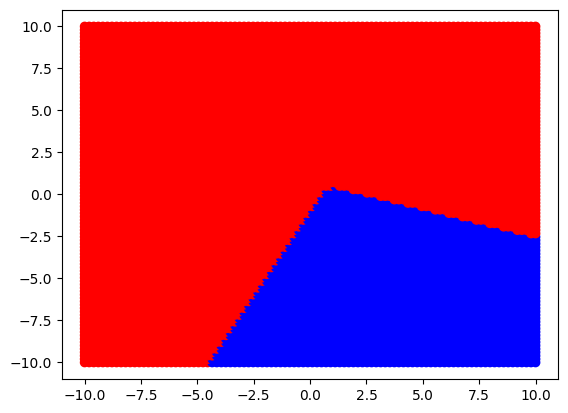

In [164]:
# plot points blue if negative red if positive
plt.scatter([x[0] for x in res],[x[1] for x in res],c=["blue" if x[2]<0 else "red" for x in res])


In [173]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def f(x,y):
    tmp = -4*x+y+3
    #tmp = sigmoid(tmp)
    return tmp
def t(x,y):
    tmp = -4*x+y+3
    #tmp = sigmoid(tmp)
    return tmp


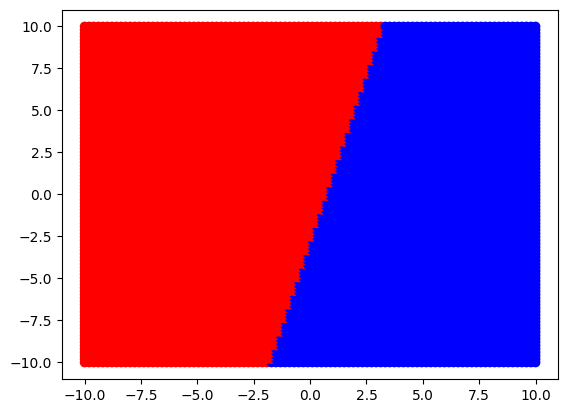

In [175]:
x = np.linspace(-10,10,100)
y = np.linspace(-10,10,100)

X,Y = np.meshgrid(x,y)

res_f = []
res_t = []
for x,y in zip(X.flatten(),Y.flatten()):
    res_f.append((x,y,f(x,y)))
    res_t.append((x,y,t(x,y)))
plt.scatter([x[0] for x in res_f],[x[1] for x in res_f],c=["blue" if x[2]<0 else "red" for x in res_f])





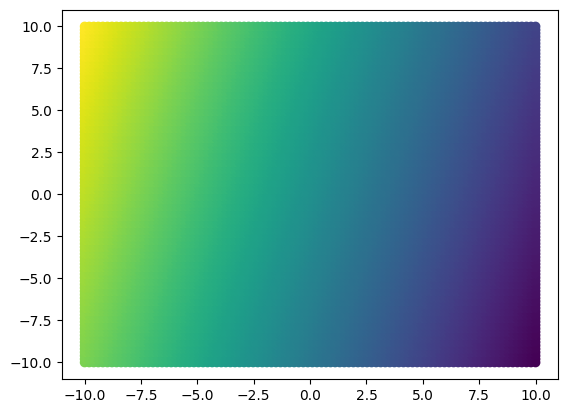

In [176]:
plt.scatter([x[0] for x in res_t],[x[1] for x in res_t],c=[x[2] for x in res_t])

In [181]:
x0 = np.array([1/np.sqrt(2), 1/np.sqrt(2)])
x1 = np.array([2/np.sqrt(2), 2/np.sqrt(2)])

def f(x):
    return -4*x[0]+2*x[1]+3



In [182]:
x2 = x0 - f(x1)*(x1-x0)/(f(x1)-f(x0))

In [186]:
x2

array([0.79289322, 0.79289322])

In [189]:
x0

array([0.70710678, 0.70710678])

In [185]:
f(x1)-f(x0)

-1.414213562373095

In [200]:
res = pd.read_csv("../../../evaluations/df_mean.csv")

In [201]:
res

,Unnamed: 0,weak,strong,td3_corne,trainer_test_1,trainer_test,best_old,hyper_td3_2_12_best_basic,trial_11
0,weak,NaN,NaN,9.607918,8.157233,9.199721,9.636198,1.853189,8.125985
1,strong,NaN,NaN,9.584207,8.131657,9.267474,9.621014,1.536571,7.889890
2,td3_corne,9.607918,9.584207,-2.867561,7.274003,8.954343,0.662693,2.945157,-1.522450
3,trainer_test_1,8.157233,8.131657,7.274003,0.669939,-0.357817,-9.103361,-9.527242,-1.371857
4,trainer_test,9.199721,9.267474,8.954343,-0.357817,0.198819,-9.012774,-11.190154,-10.056125
5,best_old,9.636198,9.621014,0.662693,-9.103361,-9.012774,-1.185464,5.016096,-8.404016
6,hyper_td3_2_12_best_basic,1.853189,1.536571,2.945157,-9.527242,-11.190154,5.016096,-7.266544,0.740242
7,trial_11,8.125985,7.889890,-1.522450,-1.371857,-10.056125,-8.404016,0.740242,-1.368695


In [202]:
Semaphore hiwiReady = 0 Semaphore studentReady = 0 Semaphore accessFreeSeats = 1 int freeWaitingSeats = 3
HiWi() {
while ( true ) {
} }
Student() { while ( true )
{ )
} }
wait(studentReady) wait ( (1) ) freeWaitingSeats += 1 signal( (2) )
signal( (3) )
// Helfe hier einem Studenten
// HiWischläfthier,fallsniemandanwesend
wait ( (4)
if (freeWaitingSeats > 0) {
freeWaitingSeats −= 1 signal ( (5) )
signal( (6) )
wait ( (7) )
// Warte auf Warteplatz
// Gebe dem HiWi Bescheid
// Student wartet hier vor der Tür // Student ist im Büro und ihm wird geholfen
} else {
// Alle Warteplätze belegt
signal( (8) ) }

SyntaxError: closing parenthesis ')' does not match opening parenthesis '{' (2940310354.py, line 6)

In [204]:
n_sampled_goal = 3
1 - (1.0 / (n_sampled_goal + 1))


0.75